### Table of contents
<a id="0"></a>
* [1. Cohort analysis](#1)
* [2. RFM Model](#2)
* [3. CLV](#3) 

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import datetime
import datetime as dt
from operator import attrgetter
import squarify
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import lifetimes

np.random.seed(42)

import random
random.seed(42)

import warnings
warnings.filterwarnings('ignore')

#### Plotting parameters

In [2]:
plt.rcParams['figure.figsize'] = (14,9) 
# plt.rcParams["figure.dpi"] = 140 
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


In [3]:
# Reading all the files
raw_path = 'Customer Segmentation/'
olist_customer = pd.read_csv(raw_path + 'customers_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'order_payments_dataset.csv')
df1 = olist_orders
df2 = olist_customer
df3 = olist_order_payments

<a id="1"></a>
<font color="darkslateblue" size=+3><b>1. Cohort analysis</b></font>

In [536]:
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    olist_orders[col] = pd.to_datetime(olist_orders[col])

In [537]:
joined = olist_orders.merge(olist_order_payments, how='left', on='order_id')

In [538]:
joined['order_months'] = joined['order_purchase_timestamp'].dt.to_period('M')
joined['cohorts'] = joined.groupby('customer_id')['order_months'].transform('min')

cohorts_data = joined.reset_index()\
                     .groupby(['cohorts', 'order_months']).agg(ClientsCount = ('customer_id', 'nunique'),
                          Revenue = ('payment_value', 'sum'),
                          Orders = ('order_id', 'count')).reset_index()

cohorts_data['periods'] = (cohorts_data.order_months - cohorts_data.cohorts).apply(attrgetter('n')) # periods for which the client have stayed

cohorts_data.head(7)

,cohorts,order_months,ClientsCount,Revenue,Orders,periods
0,2016-09,2016-09,4,252.24,4,0
1,2016-10,2016-10,324,59090.48,342,0
2,2016-12,2016-12,1,19.62,1,0
3,2017-01,2017-01,800,138488.04,850,0
4,2017-02,2017-02,1780,291908.01,1886,0
5,2017-03,2017-03,2682,449863.60,2837,0
6,2017-04,2017-04,2404,417788.03,2571,0


Majority of our clients are not recurring ones, we can't perform proper cohort analysis on retention and other possible metrics.

But we can analyze dynamics of the bussiness which i have performed in EDA part.

<a id="2"></a>
<font color="darkslateblue" size=+3><b>2. RFM Model</b></font>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

In [4]:
# df_orders = joined
df_orders =  olist_orders.merge(olist_order_payments, how='left', on='order_id')

In [5]:
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])

In [6]:
df_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,credit_card,3.0,179.12
...,...,...,...,...,...,...,...,...,...,...,...,...
103882,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,1.0,credit_card,3.0,85.08
103883,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,credit_card,3.0,195.00
103884,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,credit_card,5.0,271.01
103885,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,credit_card,4.0,441.16


In [7]:
df_orders['order_purchase_timestamp'].max()

Timestamp('2018-10-17 17:30:18')

In [8]:
snapshot_date = df_orders['order_purchase_timestamp'].max() + datetime.timedelta(days=1)

In [9]:
datamart = df_orders.groupby(['customer_id']).agg({
'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
'order_id': 'count',
'payment_value': 'sum'})

In [10]:
datamart.rename(columns = {'order_purchase_timestamp': 'Recency',
'order_id': 'Frequency',
'payment_value': 'MonetaryValue'}, inplace=True)

In [11]:
datamart.describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
Recency,99441.0,290.900192,153.667316,1.0,167.00,272.00,401.00,519.00,573.00,626.000,773.00
Frequency,99441.0,1.044710,0.381164,1.0,1.00,1.00,1.00,1.00,1.00,2.000,29.00
MonetaryValue,99441.0,160.988648,221.950728,0.0,62.01,105.29,176.97,308.24,452.98,1075.794,13664.08


So, here we can see that we have lots of `1` values in `Freqency` and some outliers in `Monetary` groups. Thus, they should be dropped and be analyzed separately

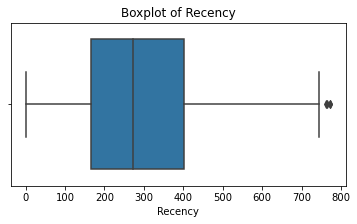

In [12]:
plt.figure(figsize=(6, 3))
sns.boxplot(x='Recency', data=datamart)
plt.title('Boxplot of Recency');
plt.show();

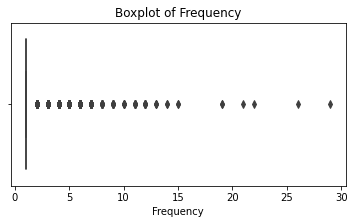

In [13]:
plt.figure(figsize=(6, 3))
sns.boxplot(x='Frequency', data=datamart)
plt.title('Boxplot of Frequency');
plt.show();

In [14]:
datamart['MonetaryValue'].describe([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    99441.000000
mean       160.988648
std        221.950728
min          0.000000
25%         62.010000
50%        105.290000
75%        176.970000
90%        308.240000
95%        452.980000
99%       1075.794000
max      13664.080000
Name: MonetaryValue, dtype: float64

Here, it seems like 95% percentile should be used to drop the outliers

In [15]:
datamart = datamart[datamart['MonetaryValue'] < 455]

In [16]:
save_datamart = datamart.copy()

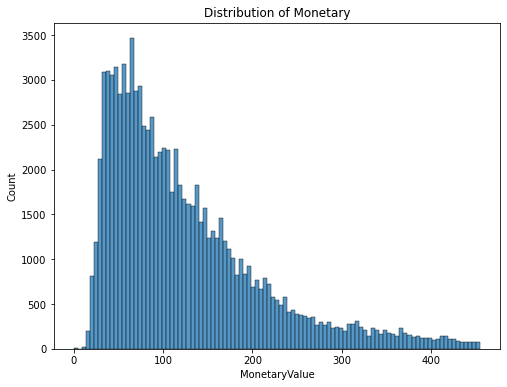

In [17]:
plt.figure(figsize=[8,6])
plt.title('Distribution of Monetary')
sns.histplot(x=datamart['MonetaryValue']);
plt.show();

For Frequency I have decided to group them by hand

In [18]:
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = [1,2,3,4])
f_quartiles = pd.cut(datamart['Frequency'], bins=[0,1,7,15,29], labels = [1,2,3,4])
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = [1,2,3,4])

In [19]:
r_triptiles = pd.qcut(datamart['Recency'], 3, labels = [1,2,3])
f_triptiles = pd.cut(datamart['Frequency'], bins=[0,1,10,29], labels = [1,2,3])
m_triptiles = pd.qcut(datamart['MonetaryValue'], 3, labels = [1,2,3])

In [20]:
datamart = datamart.assign(R = r_quartiles.values)
datamart = datamart.assign(F = f_quartiles.values)
datamart = datamart.assign(M = m_quartiles.values)

In [21]:
datamart = datamart.assign(R3 = r_triptiles.values)
datamart = datamart.assign(F3 = f_triptiles.values)
datamart = datamart.assign(M3 = m_triptiles.values)

In [22]:
def join_rfm(x): return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
def join_rfm3(x): return str(int(x['R3'])) + str(int(x['F3'])) + str(int(x['M3']))
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
datamart['RFM_Segment3'] = datamart.apply(join_rfm3, axis=1)
datamart['RFM_Score3'] = datamart[['R3','F3','M3']].sum(axis=1)

In [23]:
datamart= datamart.reset_index()
datamart

,customer_id,Recency,Frequency,MonetaryValue,R,F,M,R3,F3,M3,RFM_Segment,RFM_Score,RFM_Segment3,RFM_Score3
0,00012a2ce6f8dcda20d059ce98491703,338,1,114.74,3,1,3,2,1,2,313,7.0,212,5.0
1,000161a058600d5901f007fab4c27140,459,1,67.41,4,1,2,3,1,1,412,7.0,311,5.0
2,0001fd6190edaaf884bcaf3d49edf079,597,1,195.42,4,1,4,3,1,3,414,9.0,313,7.0
3,0002414f95344307404f0ace7a26f1d5,428,1,179.35,4,1,4,3,1,3,414,9.0,313,7.0
4,000379cdec625522490c315e70c7a9fb,199,1,107.01,2,1,3,1,1,2,213,6.0,112,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94497,fffecc9f79fd8c764f843e9951b11341,203,3,81.36,2,2,2,1,2,2,222,6.0,122,5.0
94498,fffeda5b6d849fbd39689bb92087f431,149,1,63.13,1,1,2,1,1,1,112,4.0,111,3.0
94499,ffff42319e9b2d713724ae527742af25,127,1,214.13,1,1,4,1,1,3,114,6.0,113,5.0
94500,ffffa3172527f765de70084a7e53aae8,411,1,45.50,4,1,1,3,1,1,411,6.0,311,5.0


### Analyzing RFMsegments

In [24]:
# Summary metrics per RFM score
datamart.groupby('RFM_Score').agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean',
'count'] }).round(2)

Recency Frequency MonetaryValue       
             mean      mean          mean  count
RFM_Score                                       
3.0        107.61      1.00         41.93   5754
4.0        163.84      1.02         60.35  11623
5.0        217.24      1.03         83.74  17343
6.0        291.78      1.03        122.53  23593
7.0        347.58      1.06        149.40  18236
8.0        415.87      1.06        186.52  11966
9.0        501.71      1.11        244.51   5791
10.0       500.56      2.87        257.52    186
11.0       511.00     12.70        240.31     10

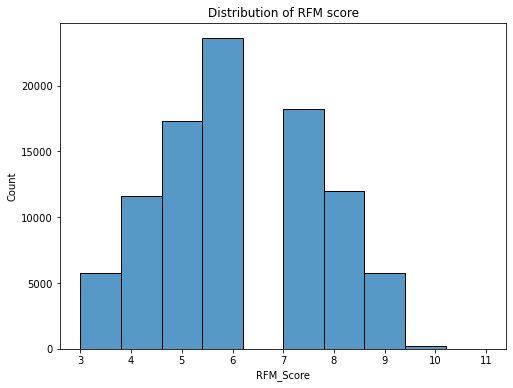

In [25]:
plt.figure(figsize=[8,6])
sns.histplot(datamart['RFM_Score'], bins=10);
plt.title('Distribution of RFM score');

### use kmeans to have some clues of segmentation

#### without normalization

In [26]:
kmeans = KMeans(n_clusters=5, max_iter=400, random_state=69)
kmeans.fit(datamart[['Recency', 'Frequency', 'MonetaryValue']])

KMeans(max_iter=400, n_clusters=5, random_state=69)

In [27]:
datamart['K_means_segment'] = kmeans.labels_

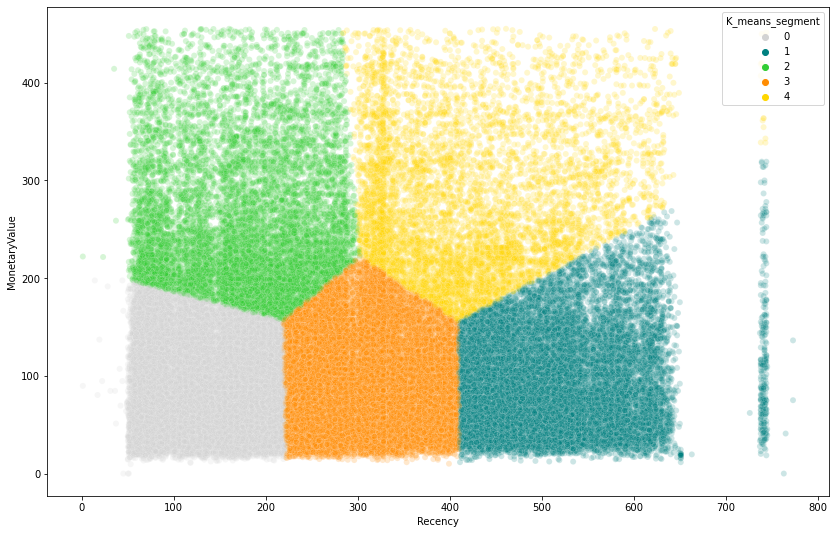

In [28]:

sns.scatterplot(x=datamart['Recency'], y = datamart['MonetaryValue'], hue=datamart['K_means_segment'], palette=['#d3d3d3', 'teal', 'limegreen', 'darkorange', 'gold'], alpha=0.2, sizes=1);

In [29]:
for i in range(5):
    print('Cluster ', i)
    print(datamart[datamart['K_means_segment']==i]['RFM_Segment3'].value_counts()[:5])
    print('')
    print('')

Cluster  0
112    10161
111    10086
113     3976
211     1262
212     1169
Name: RFM_Segment3, dtype: int64


Cluster  1
312    7355
311    7296
313    3453
322     291
321     288
Name: RFM_Segment3, dtype: int64


Cluster  2
113    6604
213    4139
123     173
223     100
Name: RFM_Segment3, dtype: int64


Cluster  3
211    9058
212    8824
213    4304
312    3049
311    2804
Name: RFM_Segment3, dtype: int64


Cluster  4
313    5407
213    1610
323     189
223      53
333       4
Name: RFM_Segment3, dtype: int64




* We can see that in `Cluster 0`, R =3 => This is the one-timers group - `GONE`
* In `Cluster 4`, most R =1 => This is the client just have joined - `ROOKIES`
* All customers in `Cluster 1` have M = 3 => This is big buyers

#### with normalization

In [30]:
scaler = MinMaxScaler()
for i in ['Recency', 'Frequency', 'MonetaryValue']:
    scaler.fit(datamart[[i]])
    datamart[i+'_normalized'] = scaler.transform(datamart[[i]])

In [31]:
kmeans = KMeans(n_clusters=5, max_iter=400, random_state=0)
kmeans.fit(datamart[['Recency_normalized', 'Frequency_normalized', 'MonetaryValue_normalized']])
datamart['K_means_normalized_segment'] = kmeans.labels_

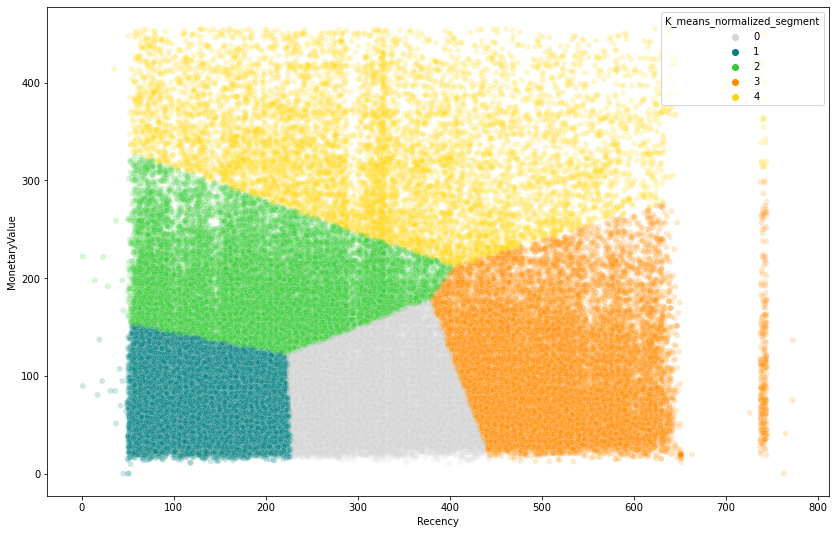

In [32]:

sns.scatterplot(x=datamart['Recency'], y = datamart['MonetaryValue'], hue=datamart['K_means_normalized_segment'], palette=['#d3d3d3', 'teal', 'limegreen', 'darkorange', 'gold'], alpha=0.2, sizes=1);
plt.show();

In [33]:
datamart['K_means_normalized_segment'].value_counts()

0    25710
1    23891
3    19798
2    17025
4     8078
Name: K_means_normalized_segment, dtype: int64

In [34]:
for i in range(5):
    print('Cluster ', i)
    print(datamart[datamart['K_means_normalized_segment']==i]['RFM_Segment3'].value_counts()[:5])
    print('')
    print('')

Cluster  0
211    8642
212    8216
311    3631
312    3029
213     827
Name: RFM_Segment3, dtype: int64


Cluster  1
111    10086
112     9786
211     1678
212     1199
113      516
Name: RFM_Segment3, dtype: int64


Cluster  2
113    8404
213    6667
313     586
212     578
112     375
Name: RFM_Segment3, dtype: int64


Cluster  3
312    7375
311    6469
313    5234
322     293
321     253
Name: RFM_Segment3, dtype: int64


Cluster  4
313    3386
213    2780
113    1660
323     130
223      72
Name: RFM_Segment3, dtype: int64




* In `Cluster 0`, R =3 => GONE
* In `Cluster 1`, most R =1 => ROOKIES
* All customers in `Cluster 4` have M = 3

    -CORE - most recent, frequent, revenue generating - core customers that should be considered as most valuable clients
    -GONE - one-timers - those clients are probably gone;
    -ROOKIE - just have joined - new clients that have joined recently
    -WHALES - big buyers, most revenue generating - whales that generate revenue
    -LOYAL - loyal users
    -REGULAR - average users - just regular customers that don't stand out

In [570]:
# Largest RFM segments
datamart.groupby('RFM_Segment3').size().sort_values(ascending=False)[:12]

RFM_Segment3
113    10580
312    10404
211    10320
213    10274
112    10161
311    10100
111    10086
212     9993
313     9781
322      397
321      384
221      329
dtype: int64

### RFM segmentation:

    -CORE - '123' - most recent, frequent, revenue generating - core customers that should be considered as most valuable clients
    -GONE - '31x' - gone, one-timers - those clients are probably gone;
    -ROOKIE - '11x' - just have joined - new clients that have joined recently
    -WHALES - '323', '213', '223 - big buyers, most revenue generating - whales that generate revenue
    -LOYAL - '221', '222', '321', '322' - loyal users
    -REGULAR - '121', '122', '211', '212', - average users - just regular customers that don't stand out

In [571]:
def segment(x):
    if x == '123':
        return 'Core'
    elif x in ['311', '312', '313']:
        return 'Gone'
    elif x in ['111', '112', '113']:
        return 'Rookies'
    elif x in ['323', '213', '223']:
        return 'Whales'
    elif x in ['221', '222', '321', '322']:
        return 'Loyal'
    else:
        return 'Regular'

In [572]:
datamart['segments'] = datamart['RFM_Segment3'].apply(segment)
datamart['segments'].value_counts(normalize=True)*100

Rookies    32.620474
Gone       32.046941
Regular    22.086305
Whales     11.496053
Loyal       1.472985
Core        0.277243
Name: segments, dtype: float64

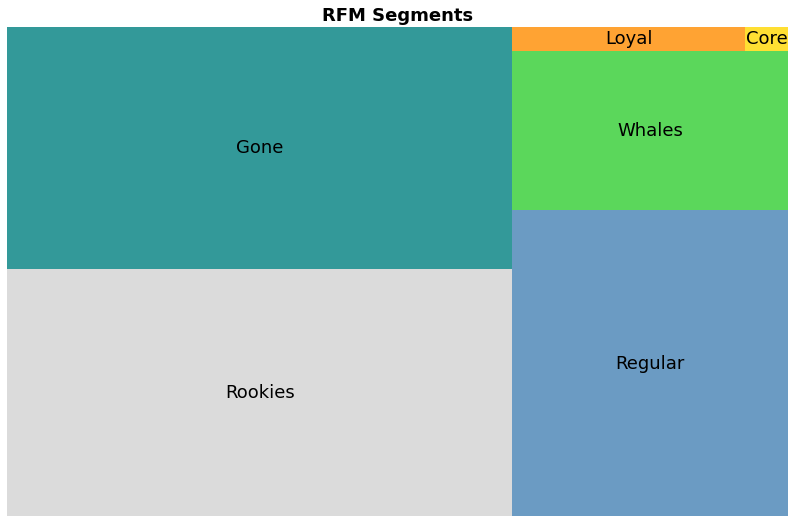

In [573]:
font = {'size'   : 18}
plt.rc('font', **font)
fig = plt.gcf()
ax = fig.add_subplot()
squarify.plot(sizes = datamart['segments'].value_counts(), 
              label = datamart['segments'].value_counts().index,
              color = ['#d3d3d3', 'teal', 'steelblue', 'limegreen', 'darkorange', 'gold'],
              alpha = 0.8)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show();

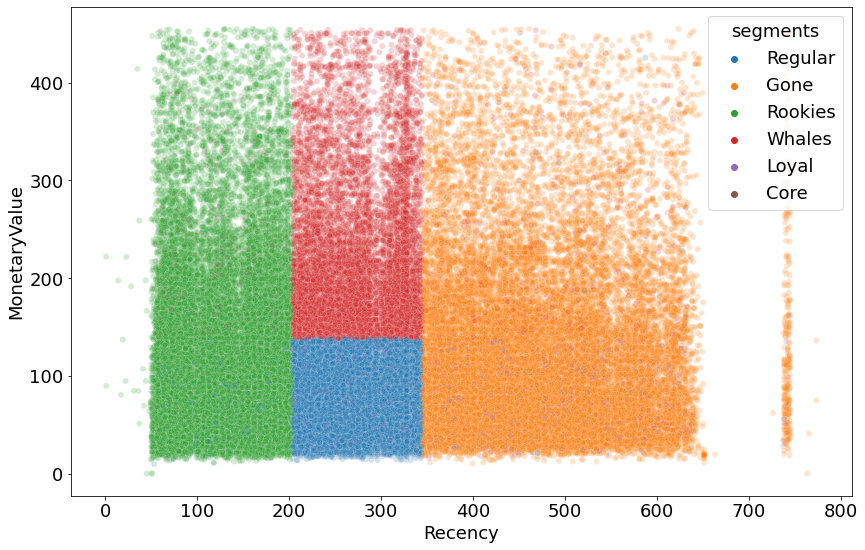

In [574]:
sns.scatterplot(x=datamart['Recency'], y = datamart['MonetaryValue'], hue=datamart['segments'], alpha=0.2);
plt.show();

<a id="3"></a>
<font color="darkslateblue" size=+3><b>3. CLV</b></font>

<a href="#0" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>

### Aggregate Model approach

In [575]:
customer = save_datamart
customer.columns = ['Age', 'Frequency', 'TotalSales']
customer.head()

,Age,Frequency,TotalSales
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,338,1,114.74
000161a058600d5901f007fab4c27140,459,1,67.41
0001fd6190edaaf884bcaf3d49edf079,597,1,195.42
0002414f95344307404f0ace7a26f1d5,428,1,179.35
000379cdec625522490c315e70c7a9fb,199,1,107.01


In [576]:
# Calculating the necessary variables for CLV calculation
Average_sales = round(np.mean(customer['TotalSales']),3)
print(f"Average sales: ${Average_sales}")

Purchase_freq = round(np.mean(customer['Frequency']), 3)
print(f"Purchase Frequency: {Purchase_freq}")

Retention_rate = customer[customer['Frequency']>1].shape[0]/customer.shape[0]
churn = round(1 - Retention_rate, 3)
print(f"Churn: {churn}%")

Average sales: $123.896
Purchase Frequency: 1.044
Churn: 0.97%


In [577]:
# Calculating the CLV
Profit_margin = 7/100 

CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
print(f"The Customer Lifetime Value (CLV) for each customer is: ${CLV}")

The Customer Lifetime Value (CLV) for each customer is: $9.33


### Cohort Model approach

In [578]:
# Transforming the data to customer level for the analysis
customer = df_orders.groupby('customer_id').agg({'order_purchase_timestamp':lambda x: x.min().month, 
                                                   'order_id': lambda x: len(x),
                                                  'payment_value': lambda x: np.sum(x)})

customer.columns = ['Start_Month', 'Frequency', 'TotalSales']
customer.head()

,Start_Month,Frequency,TotalSales
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,11,1,114.74
000161a058600d5901f007fab4c27140,7,1,67.41
0001fd6190edaaf884bcaf3d49edf079,2,1,195.42
0002414f95344307404f0ace7a26f1d5,8,1,179.35
000379cdec625522490c315e70c7a9fb,4,1,107.01


In [579]:
# Calculating CLV for each cohort
months = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Monthly_CLV = []

for i in range(1, 13):
    customer_m = customer[customer['Start_Month']==i]
    
    Average_sales = round(np.mean(customer_m['TotalSales']),3)
    
    Purchase_freq = round(np.mean(customer_m['Frequency']), 3)
    
    Retention_rate = customer_m[customer_m['Frequency']>1].shape[0]/customer_m.shape[0]
    churn = round(1 - Retention_rate, 2)
    
    CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 3)
    
    Monthly_CLV.append(CLV)


In [580]:
monthly_clv = pd.DataFrame(zip(months, Monthly_CLV), columns=['Months', 'CLV'])
display(monthly_clv.style.background_gradient())

,Months,CLV
0,Jan,11.693000
1,Feb,11.319000
2,March,12.281000
3,Apr,12.766000
4,May,12.496000
5,Jun,12.324000
6,Jul,12.171000
7,Aug,11.711000
8,Sep,12.941000
9,Oct,12.959000


<font size=3>We have 12 different CLV value for 12 months from Jan-Dec. And it is pretty clear that, customers who are acquired in different months have different CLV values attached to them. This is because, they could be acquired using different campaigns etc., so their behaviours might be different from others.</font>

### BG/NBD Model 

In [581]:
orders = df1[['customer_id', 'order_id', 'order_purchase_timestamp']]
orders.drop_duplicates(inplace=True)

customers = df2[['customer_id', 'customer_unique_id']]

elog = orders.merge(customers, how='inner')
elog.reset_index(inplace=True)

elog['order_purchase_timestamp'] = pd.to_datetime(elog['order_purchase_timestamp'])
elog['order_date'] = elog['order_purchase_timestamp'].dt.date
elog['order_date'] = pd.to_datetime(elog['order_date'])

elog = elog[['customer_unique_id', 'order_date']]
elog.columns = ['CUSTOMER_ID', 'ORDER_DATE']
elog

,CUSTOMER_ID,ORDER_DATE
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02
1,af07308b275d755c9edb36a90c618231,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13
...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09
99437,da62f9e57a76d978d02ab5362c509660,2018-02-06
99438,737520a9aad80b3fbbdad19b66b37b30,2017-08-27
99439,5097a5312c8b157bb7be58ae360ef43c,2018-01-08


#### Date range of orders

In [582]:
elog.ORDER_DATE.describe()

count                   99441
unique                    634
top       2017-11-24 00:00:00
freq                     1176
first     2016-09-04 00:00:00
last      2018-10-17 00:00:00
Name: ORDER_DATE, dtype: object

## Creating RFM Matrix based on transaction log

#### Spliting calibration and holdout period

<font size =3>I’ll split the data into a training (calibration) period and a holdout (observation) period, train the BG/NBD model</font>

In [583]:
dt.date(2018,9,28) - dt.date(2018,3,15)

datetime.timedelta(days=197)

In [584]:
calibration_period_ends = '2018-03-15'

from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(elog, 
                                                   customer_id_col = 'CUSTOMER_ID', 
                                                   datetime_col = 'ORDER_DATE', 
                                                   freq = 'D', #days
                                        calibration_period_end=calibration_period_ends,
                                        observation_period_end='2018-09-28' )


In [585]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CUSTOMER_ID,,,,,
0000f46a3911fa3c0805444483337064,0.0,0.0,370.0,0.0,197.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,154.0,0.0,197.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,121.0,0.0,197.0
00053a61a98854899e70ed204dd4bafe,0.0,0.0,15.0,0.0,197.0
0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,376.0,0.0,197.0


### Training model - MBG/NBD 

Model assumptions:

* While active, the number of transactions made by a customer follows a Poisson process
with transaction rate $\lambda$.
* Heterogeneity in $\lambda$ across customers follows a Gamma distribution with shape parameter $r$ and scale parameter $\alpha$.
* At time zero and right after each purchase the customer becomes inactive with a constant probability $p$.
* Heterogeneity in $p$ across customers follows a Gamma distribution with parameter $a$ and $b$.
* The transaction rate $\lambda$ and the dropout probability $p$ vary independently across customers.



In [586]:
from lifetimes import ModifiedBetaGeoFitter

mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.001)
mbgnbd.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'],
       verbose=True)

Optimization terminated successfully.
         Current function value: 0.072447
         Iterations: 48
         Function evaluations: 49
         Gradient evaluations: 49


<lifetimes.ModifiedBetaGeoFitter: fitted with 60966 subjects, a: 0.63, alpha: 304.52, b: 0.20, r: 0.20>

Next we want to evaluate the model to see how well it performs in the future. I evaluate performance with four plots, follows Peter Fader in this <a href="https://youtu.be/guj2gVEEx4s?t=1567">video</a> . These plots are:
- Calibration period histogram: does the model fit the training data?
- Cumulative transaction plot: does the model predict cumulative sales well?
- Incremental transaction plot: does the model capture the overall trend in transactions?
- Conditional expectations plot: can the model predict the number of purchases a customer will make based on the training data?

### Predictions for each customer

model.conditional_probability_alive(): This method computes the probability that a customer with history (frequency, recency, T) is currently alive.

In [587]:
t = 197 # days to predict in the future 
summary_cal_holdout['predicted_purchases'] = mbgnbd.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      summary_cal_holdout['frequency_cal'], 
                                                                                      summary_cal_holdout['recency_cal'], 
                                                                                      summary_cal_holdout['T_cal'])

summary_cal_holdout['p_alive'] = mbgnbd.conditional_probability_alive(summary_cal_holdout['frequency_cal'], 
                                                                         summary_cal_holdout['recency_cal'], 
                                                                         summary_cal_holdout['T_cal'])
summary_cal_holdout['p_alive'] = np.round(summary_cal_holdout['p_alive'] / summary_cal_holdout['p_alive'].max(), 2)


In [588]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases,p_alive
CUSTOMER_ID,,,,,,,
0000f46a3911fa3c0805444483337064,0.0,0.0,370.0,0.0,197.0,0.011559,0.25
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,154.0,0.0,197.0,0.017619,0.26
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,121.0,0.0,197.0,0.019097,0.26
00053a61a98854899e70ed204dd4bafe,0.0,0.0,15.0,0.0,197.0,0.025921,0.27
0005e1862207bf6ccc02e4228effd9a0,0.0,0.0,376.0,0.0,197.0,0.011446,0.24
...,...,...,...,...,...,...,...
fffbf87b7a1a6fa8b03f081c5f51a201,0.0,0.0,78.0,0.0,197.0,0.021409,0.27
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,280.0,0.0,197.0,0.013528,0.25
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,95.0,0.0,197.0,0.020435,0.27


### Calibration period histogram

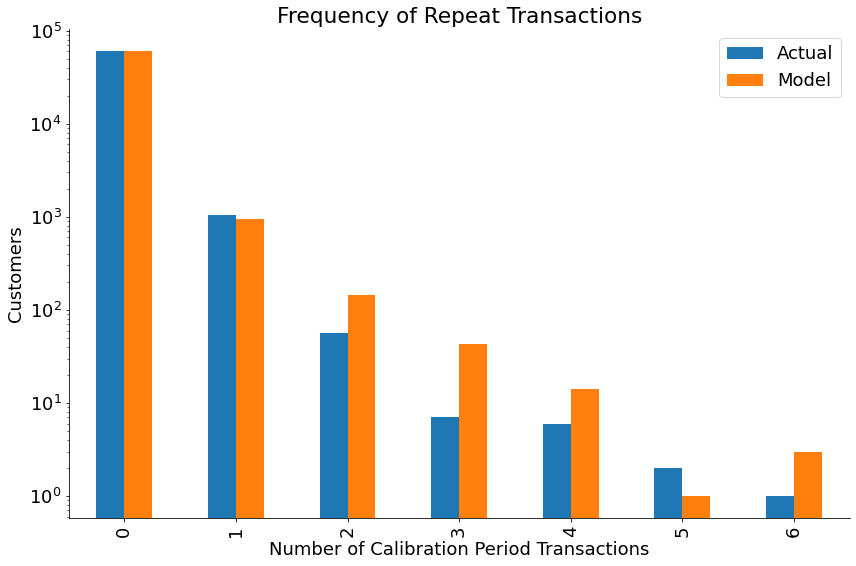

In [589]:
from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbgnbd, max_frequency=7)
ax.set_yscale('log') #log10
sns.despine();
plt.show();

### Conditional expectations plot

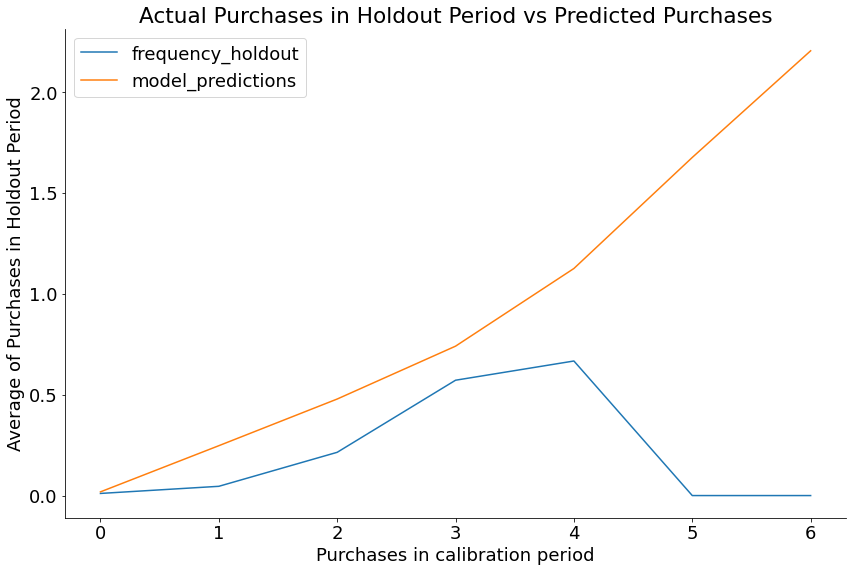

In [590]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(mbgnbd, summary_cal_holdout)
sns.despine();
plt.show();

The model performs finely to three calibration period purchases but diverges from the holdout data because of the distribution of the data.

### Customer Probability History

Probability that customer is alive today is [0.2]


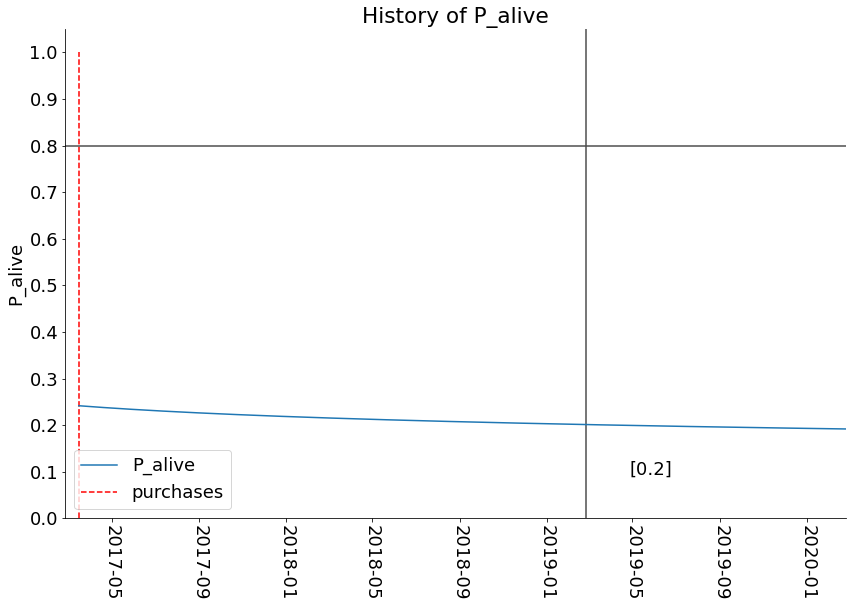

In [591]:
from lifetimes.plotting import plot_history_alive
from datetime import date
from pylab import figure, text, scatter, show

individual = summary_cal_holdout.iloc[4942]

id = individual.name
t = 365*50

today =datetime.date(2019, 2, 25)
two_year_ago = today.replace(year=today.year - 2)
one_year_from_now = today.replace(year=today.year + 1)

sp_trans = elog.loc[elog['CUSTOMER_ID'] == id]

from lifetimes.utils import calculate_alive_path

t = (today - sp_trans.ORDER_DATE.min().date()).days
p_alive_today = pd.DataFrame(calculate_alive_path(mbgnbd, sp_trans, 'ORDER_DATE', t, freq='D'))[0].tail(1).values
p_alive_today = np.round(p_alive_today[0], 2)
print('Probability that customer is alive today is', p_alive_today)

t = (one_year_from_now - sp_trans.ORDER_DATE.min().date()).days
ax = plot_history_alive(mbgnbd, t, sp_trans, 'ORDER_DATE', start_date=two_year_ago) #, start_date='2016-01-01'
ax.vlines(x=today, ymin=0, ymax=1.05, colors='#4C4C4C')
ax.hlines(y=0.8, xmin=two_year_ago, xmax=one_year_from_now, colors='#4C4C4C')

ax.set_xlim(two_year_ago, one_year_from_now) # sp_trans.ORDER_DATE.min()
ax.set_ylim(0, 1.05)

plt.xticks(rotation=-90)
text(0.75, 0.1, p_alive_today, ha='center', va='center', transform=ax.transAxes)

sns.despine()
plt.show();

### Cumulative transaction plot

In [592]:
elog.columns = ['CUSTOMER_ID', 'date']

In [593]:
# Get expected and actual repeated cumulative transactions.

from lifetimes.utils import expected_cumulative_transactions

t = (elog.date.max() - elog.date.min()).days
df = expected_cumulative_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t)

In [594]:
df.tail()

,actual,predicted
768,2383,3562.041287
769,2383,3573.440717
770,2383,3584.830771
771,2383,3596.211473
772,2384,3607.582847


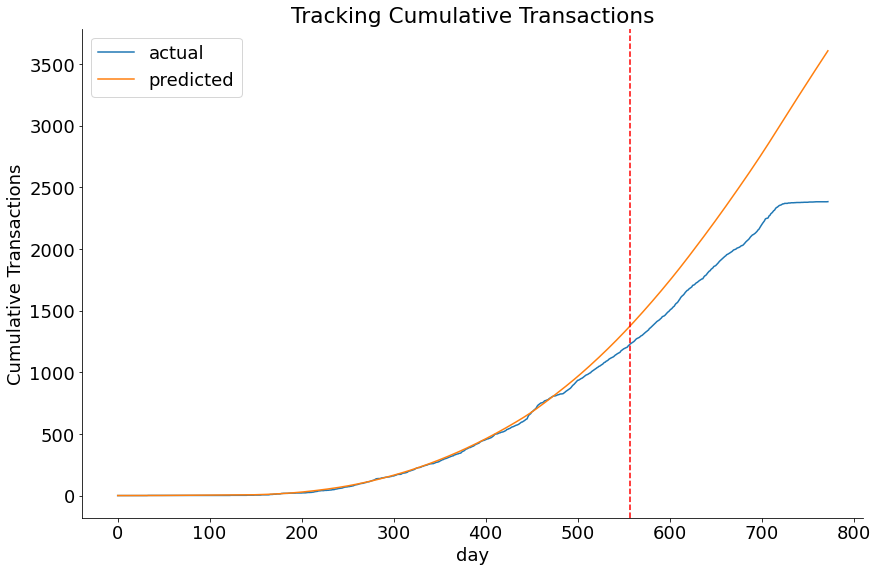

In [595]:
# Calibration period = 2016-09-04 to 2017-09-30
from datetime import datetime

cal = datetime.strptime('2018-03-15', '%Y-%m-%d')

from lifetimes.plotting import plot_cumulative_transactions
t = (elog.date.max() - elog.date.min()).days
t_cal = (cal - elog.date.min()).days
plot_cumulative_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t, t_cal, freq='D')
sns.despine()
plt.show();

The red line represents the boundary between the calibration period on the left and the holdout period on the right. As you can see, the BG/NBD model does a pretty swell job at predicting cumulative transactions.

### Incremental transaction plot

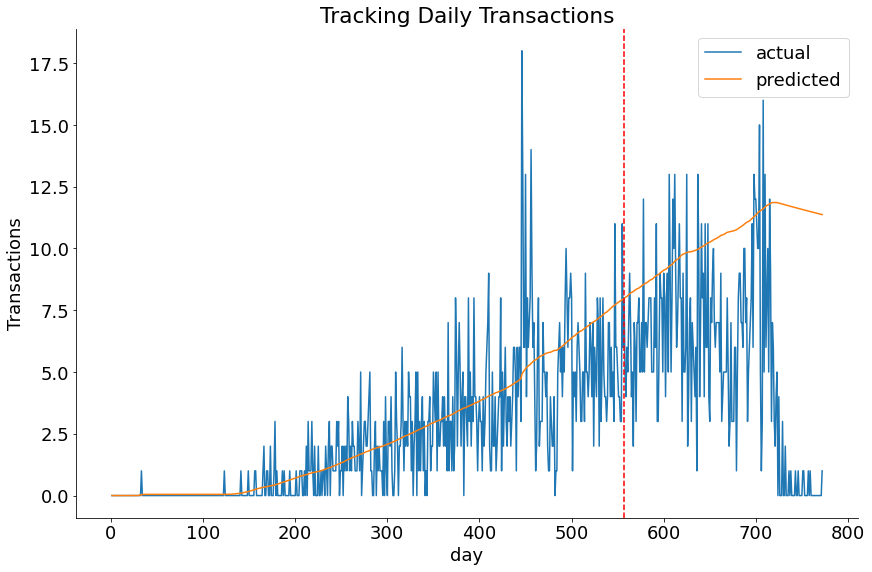

In [596]:
from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(mbgnbd, elog, 'date', 'CUSTOMER_ID', t, t_cal, freq='D')
sns.despine()
plt.show();

This plot shows that the model does a decent job capturing general trends in the data.

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go to TOC</a>